
=== Evaluating Q-Learning for pGen = 0.2 ===

=== Q-Learning (pGen=0.2) Policy Training Run 1 ===
Episode 10

=== Q-Learning (pGen=0.2) Policy Training Run 2 ===
Episode 10

=== Q-Learning (pGen=0.2) Policy Training Run 3 ===
Episode 10

=== Q-Learning (pGen=0.2) Policy Training Run 4 ===
Episode 10

=== Q-Learning (pGen=0.2) Policy Training Run 5 ===
Episode 10

=== Evaluating Q-Learning for pGen = 0.4 ===

=== Q-Learning (pGen=0.4) Policy Training Run 1 ===
Episode 10

=== Q-Learning (pGen=0.4) Policy Training Run 2 ===
Episode 10

=== Q-Learning (pGen=0.4) Policy Training Run 3 ===
Episode 10

=== Q-Learning (pGen=0.4) Policy Training Run 4 ===
Episode 10

=== Q-Learning (pGen=0.4) Policy Training Run 5 ===
Episode 10

=== Evaluating Q-Learning for pGen = 0.6000000000000001 ===

=== Q-Learning (pGen=0.6000000000000001) Policy Training Run 1 ===
Episode 10

=== Q-Learning (pGen=0.6000000000000001) Policy Training Run 2 ===
Episode 10

=== Q-Learning (pGen=0.6000000000000001) Policy 

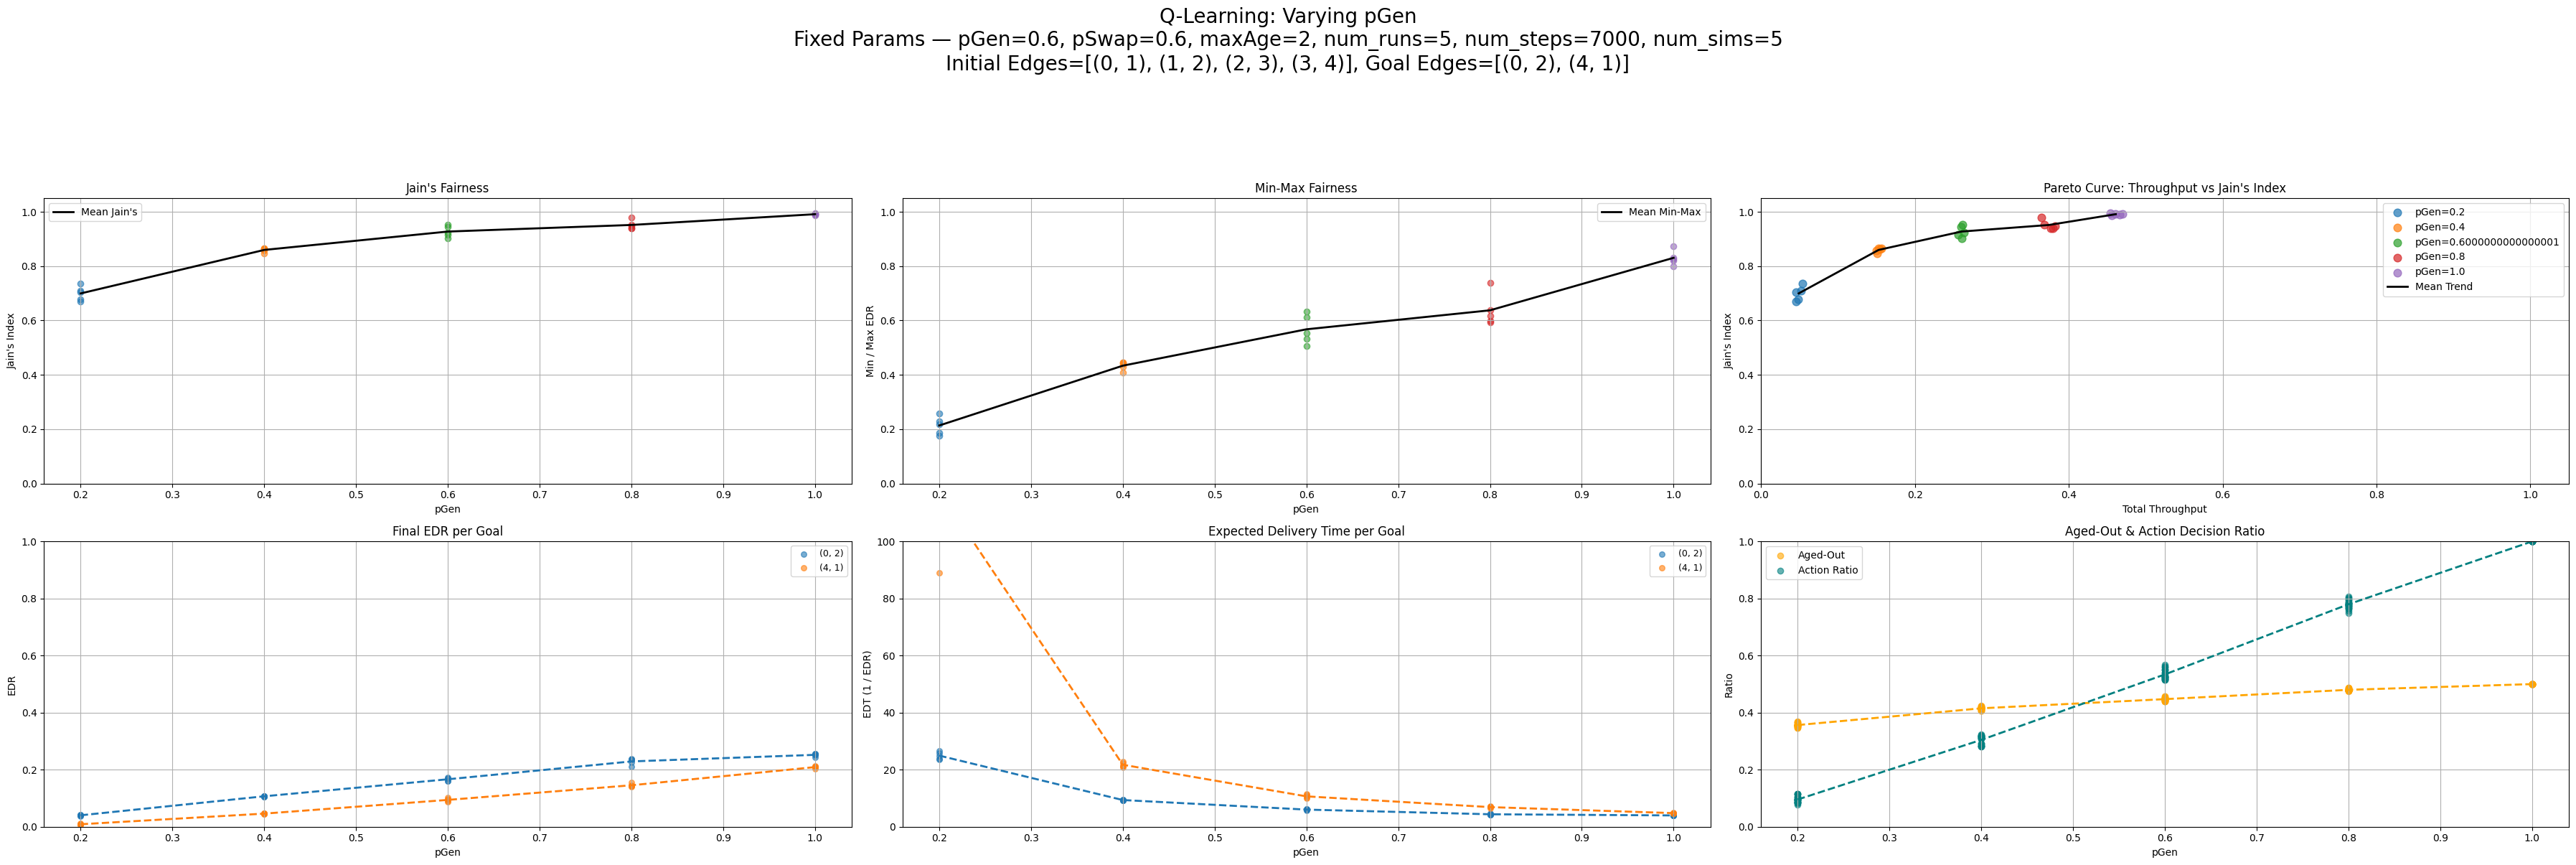

Done


In [ ]:
from linearApprox import *

class QuantumNetworkQLearning:
    def __init__(self, edges, goalEdges, pSwap, pGen, maxAge, alpha, gamma, epsilon, softmax, temperature, temperature_decay):
        self.edges = edges
        self.goalEdges = goalEdges
        self.pSwap = pSwap
        self.pGen = pGen
        self.maxAge = maxAge
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.softmax = softmax
        self.temperature = temperature
        self.temperature_decay = temperature_decay

        feature_size = len(edges) + len(goalEdges)
        self.Q = LinearQApproximator(feature_size=feature_size)

        self.goal_success_queues = {goal: [] for goal in self.goalEdges}

    def choose_action(self, state, training=True):
        ent_state, _ = state
        possible_actions = getPossibleActions(ent_state, self.goalEdges)

        features = featurize_state(state, self.goalEdges)
        q_scores = [(action, self.Q.get_q_value(features, action)) for action in possible_actions]


        if self.softmax and training:
            q_vals = [q for (_, q) in q_scores]
            probs = softmax_probs(q_vals, self.temperature)
            chosen_action = random.choices([a for a, _ in q_scores], weights=probs)[0]
        else:
            if training and random.random() < self.epsilon:
                chosen_action = random.choice(possible_actions)
            else:
                chosen_action = max(q_scores, key=lambda x: x[1])[0]

        return chosen_action

    def train(self, num_episodes=10, max_steps=1000, plot=False):
        for episode in range(num_episodes):
            ent_state = [(edge, -1) for edge in self.edges]
            edrs = {goal: 0.0 for goal in self.goalEdges}
            state = get_augmented_state(ent_state, edrs, goal_order=self.goalEdges)

            self.goal_success_queues = {goal: [] for goal in self.goalEdges}
            total_timesteps = 1

            for step in range(max_steps):
                action = self.choose_action(state, training=True)
                next_state = performAction(action, state)
                next_state = ageEntanglements(next_state, self.maxAge)
                next_state = generateEntanglement(next_state, self.pGen)
                
                # Determine success before reward (but DO NOT manually update the success queues here)
                consumed_edges, goal = action
                success = False
                if goal is not None and consumed_edges:
                    success_prob = self.pSwap ** (len(consumed_edges) - 1)
                    success = random.random() < success_prob


                reward = getReward(
                    action=action,
                    goal_success_queues=self.goal_success_queues,
                    total_timesteps=total_timesteps,
                    pSwap=self.pSwap,
                    success=success
                )

                # Augment new state with updated EDR snapshot
                edr_snapshot = {
                    g: sum(self.goal_success_queues[g]) / max(1, len(self.goal_success_queues[g]))
                    for g in self.goalEdges
                }
                next_state = get_augmented_state(next_state[0], edr_snapshot, goal_order=self.goalEdges)

                # Q-learning update
                features = featurize_state(state, self.goalEdges)
                next_features = featurize_state(next_state, self.goalEdges)
                possible_next_actions = getPossibleActions(next_state[0], self.goalEdges)

                max_next_q = max([self.Q.get_q_value(next_features, a) for a in possible_next_actions], default=0.0)
                target = reward + self.gamma * max_next_q

                self.Q.update(features, action, target, self.alpha)


                state = next_state
                total_timesteps += 1

            # Optional: Decay temperature
            if self.softmax and self.temperature_decay:
                self.temperature = max(0.01, self.temperature * self.temperature_decay)

            if (episode + 1) % 10 == 0:
                print(f"Episode {episode + 1}")

# === Q-Learning Wrapper for Experiment Framework ===
def train_q_learning_policy(edges, goal_edges, p_swap, p_gen, max_age, seed=None, **kwargs):
    random.seed(seed)
    np.random.seed(seed)

    agent = QuantumNetworkQLearning(
        edges=edges,
        goalEdges=goal_edges,
        pSwap=p_swap,
        pGen=p_gen,
        maxAge=max_age,
        alpha=kwargs.get("alpha", 0.1),
        gamma=kwargs.get("gamma", 0.99),
        epsilon=kwargs.get("epsilon", 0.001),
        softmax=kwargs.get("softmax", False),
        temperature=kwargs.get("temperature", 1.0),
        temperature_decay=kwargs.get("temperature_decay", 0.9),
    )
    agent.train(
        num_episodes=kwargs.get("num_episodes", 5),
        max_steps=kwargs.get("max_steps", 1000),
        plot=False
    )
    return agent.Q

# === Setup parameters ===
edges = [(0, 1), (1,2), (2,3), (3,4)]
goal_edges = [(0, 2), (4, 1)]
pSwap = 0.6
pGen = 0.6
maxAge = 2

compare_policies_across_param(
    policy_name="Q-Learning",
    policy_train_fn=train_q_learning_policy,
    param_name="pGen",
    param_values=[0.2 * i for i in range(1, 6)],  
    edges=edges,
    goal_edges=goal_edges,
    p_gen=0.6, 
    p_swap=0.6,
    max_age=maxAge,
    train_kwargs={
        "alpha": 0.1,
        "gamma": 0.99,
        "epsilon": 0.1,
        "num_episodes": 10,
        "max_steps": 10000,
        "temperature": 1.0,
        "temperature_decay": 0.98,
        "softmax": False
    },
    validate_kwargs={}, 
    plot=True,
    num_runs=5,
    num_steps=7000,
    num_simulations=5
)
print('Done')


Episode 10
Episode 20
Episode 30


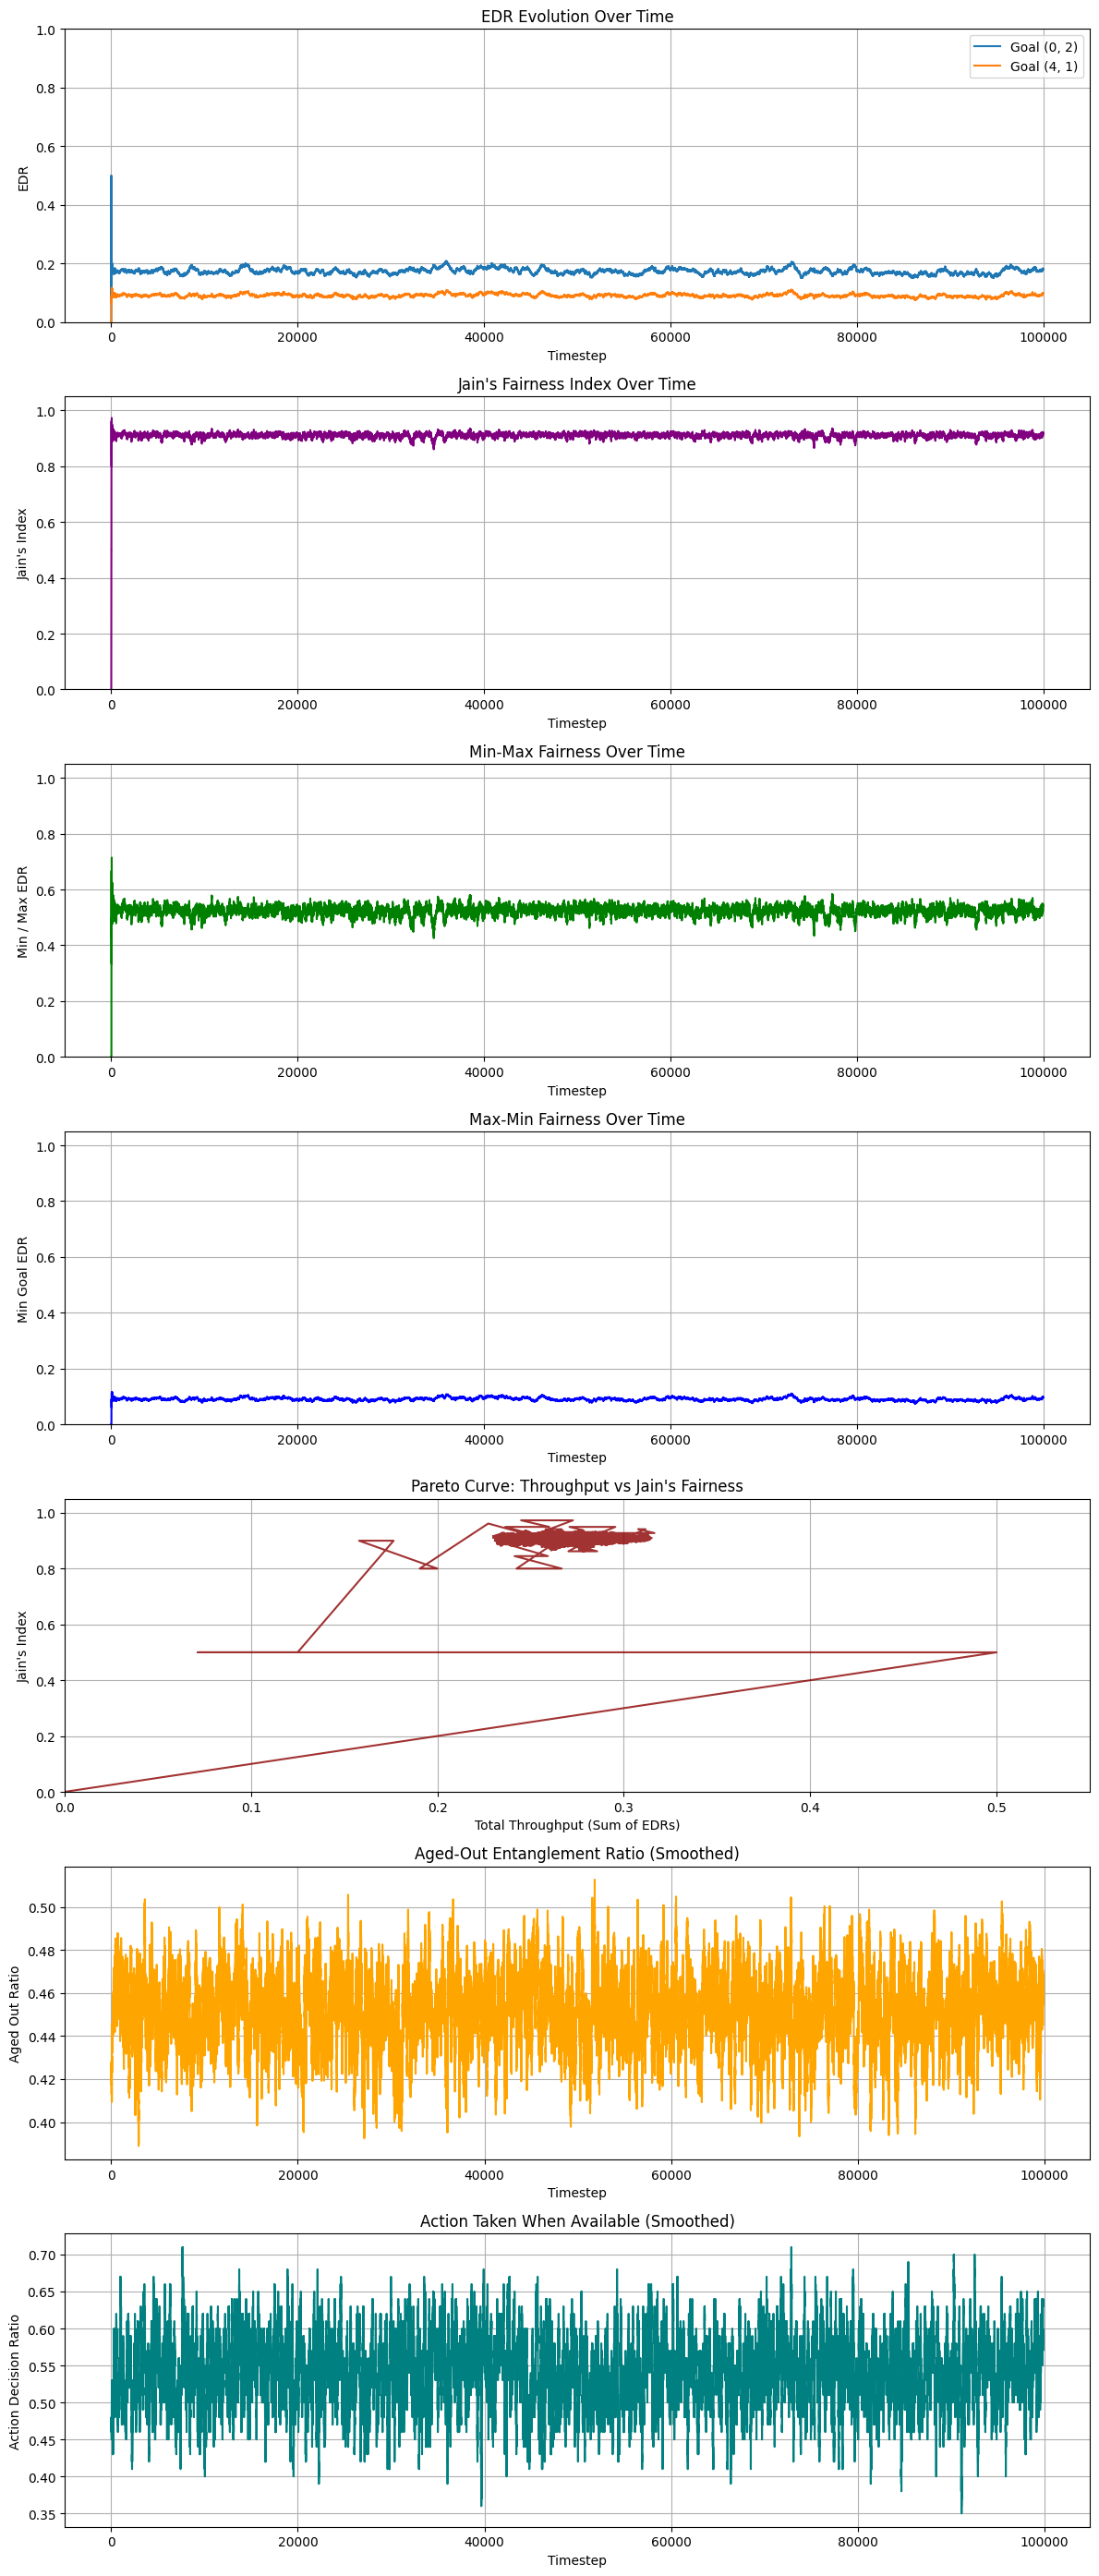

Done!


In [2]:
# === Setup parameters ===
edges = [(0, 1), (1,2), (2,3), (3,4)]
goal_edges = [(0, 2), (4, 1)]
pSwap = 0.6
pGen = 0.6
maxAge = 2

# === Train Q-Learning agent ===
Q = train_q_learning_policy(
    edges=edges,
    goal_edges=goal_edges,
    p_swap=pSwap,
    p_gen=pGen,
    max_age=maxAge,
    seed=42,
    alpha=0.1,
    gamma=0.99,
    epsilon=0.05,
    num_episodes=30,
    max_steps=20000,
    softmax=False,
    temperature=2,
    temperature_decay=0.999
)

# === Simulate policy (with EDR tracking) ===
simulate_policy(
    Q_table=Q,
    edges=edges,
    goal_edges=goal_edges,
    p_swap=pSwap,
    p_gen=pGen,
    max_age=maxAge,
    num_steps=100000,
    edr_window_size=1000,
    plot=True
)
print('Done!')

In [3]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math
from collections import defaultdict

def jains_index(edrs):
    """Compute Jain's Fairness Index."""
    if all(edr == 0 for edr in edrs.values()):
        return 0.0
    numerator = sum(edrs.values())**2
    denominator = len(edrs) * sum(v**2 for v in edrs.values())
    return numerator / denominator if denominator > 0 else 0.0

def min_max_fairness(edrs):
    """Compute Min-Max Fairness (min / max)."""
    values = list(edrs.values())
    min_val, max_val = min(values), max(values)
    if max_val == 0:
        return 0.0
    return min_val / max_val

def rolling_average(data, window):
    return np.convolve(data, np.ones(window)/window, mode='valid')

def simulate_policy(Q_table, edges, goal_edges, p_swap, p_gen, max_age, num_steps, bin_size, edr_window_size=100, plot=True):
    raw_state = [(edge, -1) for edge in edges]
    goal_success_counts = {goal: 0 for goal in goal_edges}
    recent_goal_history = {goal: [] for goal in goal_edges}  # Rolling window

    edr_history = {goal: [] for goal in goal_edges}
    jain_history = []
    min_max_history = []
    max_min_history = []
    throughput_history = []
    aged_out_history = []
    action_ratio_history = []

    current_state = get_augmented_state(raw_state, {g: 0 for g in goal_edges}, bin_size, goal_order=goal_edges)

    for step in range(num_steps):
        ent_state, _ = current_state
        possible_actions = getPossibleActions(ent_state, goal_edges)
        actions_available = len(possible_actions) > 0 and possible_actions != [([], None)]

        best_action = ([], None)
        best_score = -float("inf")

        for action in possible_actions:
            q_val = Q_table.get_q_value(current_state, action)
            if q_val > best_score:
                best_score = q_val
                best_action = action
        unseen = not Q_table.has_seen(current_state, action)
        if unseen:
            print("Unseen state-action during simulation!")
            print(current_state, action)

        action_taken = best_action != ([], None)
        action_ratio_history.append(1.0 if action_taken else 0.0)

        num_existing_before = sum(1 for _, age in ent_state if age >= 0)
        current_state = performAction(best_action, current_state)
        current_state = ageEntanglements(current_state, max_age)
        num_existing_after = sum(1 for _, age in current_state[0] if age >= 0)

        current_state = generateEntanglement(current_state, p_gen)
        num_generated_after = sum(1 for _, age in current_state[0] if age == 1)

        num_aged_out = num_existing_before - num_existing_after
        aged_out_ratio = num_aged_out / (num_aged_out + num_generated_after) if (num_aged_out + num_generated_after) > 0 else 0.0
        aged_out_history.append(aged_out_ratio)

        # Handle goal success
        consumed_edges, goal = best_action
        for g in goal_edges:
            if g == goal and consumed_edges:
                success = random.random() < (p_swap ** (len(consumed_edges) - 1))
                if success:
                    goal_success_counts[g] += 1
                    recent_goal_history[g].append(1)
                else:
                    recent_goal_history[g].append(0)
            else:
                recent_goal_history[g].append(0)


        for g in goal_edges:
            if len(recent_goal_history[g]) > edr_window_size:
                recent_goal_history[g].pop(0)

        edrs = {g: sum(recent_goal_history[g]) / len(recent_goal_history[g]) for g in goal_edges}
        for g in goal_edges:
            edr_history[g].append(edrs[g])

        # Compute fairness metrics
        throughput = sum(edrs.values())
        fairness = jains_index(edrs)
        minmax = min_max_fairness(edrs)
        maxmin = min(edrs.values())

        throughput_history.append(throughput)
        jain_history.append(fairness)
        min_max_history.append(minmax)
        max_min_history.append(maxmin)

        # Update current state with latest EDR bins
        current_state = get_augmented_state(current_state[0], edrs, bin_size, goal_order=goal_edges)

    # Smooth plots
    def rolling_average(series, window):
        return np.convolve(series, np.ones(window) / window, mode='valid')

    smoothed_aged_out = rolling_average(aged_out_history, 100)
    smoothed_action_ratio = rolling_average(action_ratio_history, 100)

    if plot:
        fig, axs = plt.subplots(7, 1, figsize=(12, 28))

        for goal in goal_edges:
            axs[0].plot(edr_history[goal], label=f'Goal {goal}')
        axs[0].set_title('EDR Evolution Over Time')
        axs[0].set_xlabel('Timestep')
        axs[0].set_ylabel('EDR')
        axs[0].legend()
        axs[0].grid(True)
        axs[0].set_ylim(0, 1)

        axs[1].plot(jain_history, color='purple')
        axs[1].set_title("Jain's Fairness Index Over Time")
        axs[1].set_xlabel('Timestep')
        axs[1].set_ylabel("Jain's Index")
        axs[1].grid(True)
        axs[1].set_ylim(0, 1.05)

        axs[2].plot(min_max_history, color='green')
        axs[2].set_title("Min-Max Fairness Over Time")
        axs[2].set_xlabel('Timestep')
        axs[2].set_ylabel("Min / Max EDR")
        axs[2].grid(True)
        axs[2].set_ylim(0, 1.05)

        axs[3].plot(max_min_history, color='blue')
        axs[3].set_title("Max-Min Fairness Over Time")
        axs[3].set_xlabel('Timestep')
        axs[3].set_ylabel("Min Goal EDR")
        axs[3].grid(True)
        axs[3].set_ylim(0, 1.05)

        axs[4].plot(throughput_history, jain_history, color='darkred', alpha=0.8)
        axs[4].set_title("Pareto Curve: Throughput vs Jain's Fairness")
        axs[4].set_xlabel("Total Throughput (Sum of EDRs)")
        axs[4].set_ylabel("Jain's Index")
        axs[4].grid(True)
        axs[4].set_xlim(0, max(throughput_history) * 1.1)
        axs[4].set_ylim(0, 1.05)

        axs[5].plot(smoothed_aged_out, color='orange')
        axs[5].set_title("Aged-Out Entanglement Ratio (Smoothed)")
        axs[5].set_xlabel("Timestep")
        axs[5].set_ylabel("Aged Out Ratio")
        axs[5].grid(True)

        axs[6].plot(smoothed_action_ratio, color='teal')
        axs[6].set_title("Action Taken When Available (Smoothed)")
        axs[6].set_xlabel("Timestep")
        axs[6].set_ylabel("Action Decision Ratio")
        axs[6].grid(True)

        plt.tight_layout()
        plt.show()

    return (
        goal_success_counts,
        num_steps,
        edr_history,
        jain_history,
        min_max_history,
        throughput_history,
        max_min_history,
        smoothed_aged_out,
        smoothed_action_ratio
    )
    

def validate_policy_simulation(Q_table, edges, goal_edges, p_swap, p_gen, max_age, num_steps, num_simulations, seed=10, plot=True, window=1000):
    all_edr_histories = []
    all_jain_histories = []
    all_min_max_histories = []
    all_max_min_histories = []
    all_throughput_histories = []
    all_aged_out_histories = []
    all_action_ratio_histories = []

    final_edr_means = []
    final_jains = []
    final_min_max = []
    final_max_min = []

    for sim in range(num_simulations):
        random.seed(seed + sim)
        _, _, edr_history, jain_history, min_max_history, throughput_history, max_min_history, aged_out_ratio_history, action_ratio_history = simulate_policy(
            Q_table, edges, goal_edges, p_swap, p_gen, max_age, num_steps, plot=False
        )

        all_edr_histories.append(edr_history)
        all_jain_histories.append(jain_history)
        all_min_max_histories.append(min_max_history)
        all_max_min_histories.append(max_min_history)
        all_throughput_histories.append(throughput_history)
        all_aged_out_histories.append(aged_out_ratio_history)
        all_action_ratio_histories.append(action_ratio_history)

        final_edr_per_goal = {
            goal: np.mean(edr_history[goal][-window:]) for goal in goal_edges
        }
        total_throughput = sum(final_edr_per_goal.values())
        final_jain = jains_index(final_edr_per_goal)
        final_minmax = min_max_fairness(final_edr_per_goal)
        final_maxmin = min(final_edr_per_goal.values())

        final_edr_means.append(total_throughput)
        final_jains.append(final_jain)
        final_min_max.append(final_minmax)
        final_max_min.append(final_maxmin)

    mean_final_edrs_by_goal = {
        goal: np.mean([np.mean(edr_history[goal][-window:]) for edr_history in all_edr_histories])
        for goal in goal_edges
    }

    mean_final_edts_by_goal = {
        goal: 1.0 / (mean_final_edrs_by_goal[goal] + 1e-8)
        for goal in goal_edges
    }

    if plot:
        fig, axs = plt.subplots(2, 3, figsize=(22, 10))
        axs = axs.flatten()

        # EDRs by Goal
        for goal in goal_edges:
            edr_vals = [np.mean(edr_history[goal][-window:]) for edr_history in all_edr_histories]
            axs[0].plot(range(num_simulations), edr_vals, marker='o', label=f"Goal {goal}")

        axs[0].set_title("Final EDRs per Simulation")
        axs[0].set_xlabel("Simulation")
        axs[0].set_ylabel("Mean Final EDR (last N steps)")
        axs[0].set_ylim(0, 1)
        axs[0].grid(True)
        axs[0].legend()


        # Jain's Index
        axs[1].plot(final_jains, marker='o', color='purple')
        axs[1].set_title("Jain's Fairness Index")
        axs[1].set_ylabel("Jain's Index")
        axs[1].set_xlabel("Simulation")
        axs[1].grid(True)
        axs[1].set_ylim(0, 1.05)

        # Pareto Curve: Throughput vs Jain
        axs[2].scatter(final_edr_means, final_jains, c='darkred')
        axs[2].set_title("Pareto Curve")
        axs[2].set_xlabel("Throughput (Sum of EDRs)")
        axs[2].set_ylabel("Jain's Index")
        axs[2].grid(True)
        axs[2].set_xlim(0, max(final_edr_means) * 1.1)
        axs[2].set_ylim(0, 1.05)

        # Avg aged-out ratio
        avg_aged = [np.mean(sim[-window:]) for sim in all_aged_out_histories]
        axs[3].plot(avg_aged, color='orange')
        axs[3].set_title("Aged-Out Entanglement Ratio")
        axs[3].set_xlabel("Simulation")
        axs[3].set_ylabel("Ratio")
        axs[3].set_ylim(0, 1.05)
        axs[3].grid(True)

        # Avg action ratio
        avg_actions = [np.mean(sim[-window:]) for sim in all_action_ratio_histories]
        axs[4].plot(avg_actions, color='teal')
        axs[4].set_title("Action Decision Ratio")
        axs[4].set_xlabel("Simulation")
        axs[4].set_ylabel("Ratio")
        axs[4].set_ylim(0, 1.05)
        axs[4].grid(True)

        axs[5].axis('off')  # Empty last subplot

        plt.tight_layout()
        plt.show()

    return (
        mean_final_edrs_by_goal,
        mean_final_edts_by_goal,
        np.mean(final_jains),
        np.mean(final_min_max),
        np.mean(final_max_min),
        all_throughput_histories,
        all_jain_histories,
        all_aged_out_histories,
        all_action_ratio_histories
    )

def run_policy_experiments(
    train_policy_fn,
    policy_name,
    edges,
    goal_edges,
    p_swap,
    p_gen,
    max_age,
    num_runs=10,
    num_steps=30000,
    num_simulations=20,
    train_kwargs={},
    validate_kwargs={},
    plot=False):
    final_edrs_by_goal = {goal: [] for goal in goal_edges}
    final_edts_by_goal = {goal: [] for goal in goal_edges}
    final_jains = []
    final_minmax = []
    final_maxmin = []
    all_throughput_histories = []
    all_jain_histories = []
    all_aged_out_histories = []
    all_action_ratio_histories = []

    for seed in range(num_runs):
        print(f"\n=== {policy_name} Policy Training Run {seed + 1} ===")
        random.seed(seed)
        np.random.seed(seed)

        Q_table = train_policy_fn(
            edges=edges,
            goal_edges=goal_edges,
            p_swap=p_swap,
            p_gen=p_gen,
            max_age=max_age,
            seed=seed,
            **train_kwargs
        )

        results = validate_policy_simulation(
            Q_table=Q_table,
            edges=edges,
            goal_edges=goal_edges,
            p_swap=p_swap,
            p_gen=p_gen,
            max_age=max_age,
            num_steps=num_steps,
            num_simulations=num_simulations,
            plot=False,
            seed=seed,
            **validate_kwargs
        )

        (
            mean_final_edrs_by_goal,
            mean_final_edts_by_goal,
            mean_final_jain,
            mean_final_min_max,
            mean_final_max_min,
            throughput_histories,
            jain_histories,
            aged_out_histories,
            action_ratio_histories
        ) = results

        for goal in goal_edges:
            final_edrs_by_goal[goal].append(mean_final_edrs_by_goal[goal])
            final_edts_by_goal[goal].append(mean_final_edts_by_goal[goal])

        final_jains.append(mean_final_jain)
        final_minmax.append(mean_final_min_max)
        final_maxmin.append(mean_final_max_min)
        all_throughput_histories.append(throughput_histories)
        all_jain_histories.append(jain_histories)
        all_aged_out_histories.append(aged_out_histories)
        all_action_ratio_histories.append(action_ratio_histories)

    if plot:
        print("PLOTTING...")
        num_policies = num_runs
        throughputs = [
            sum(final_edrs_by_goal[goal][i] for goal in goal_edges)
            for i in range(num_policies)
        ]

        fig, axs = plt.subplots(2, 3, figsize=(34, 12))
        axs = axs.flatten()

        for goal in goal_edges:
            axs[0].plot(final_edrs_by_goal[goal], marker='o', label=f"Goal {goal}")
        axs[0].set_title("Mean Final EDR per Goal")
        axs[0].set_ylim(0, 1)
        axs[0].set_xlabel("Policy Run")
        axs[0].legend()
        axs[0].grid(True)

        axs[1].plot(final_jains, label="Jain's Index", color='purple')
        axs[1].plot(final_minmax, label='Min-Max Fairness', color='green')
        axs[1].plot(final_maxmin, label='Max-Min Fairness', color='blue')
        axs[1].set_title("Fairness Metrics")
        axs[1].set_ylim(0, 1)
        axs[1].set_xlabel("Policy Run")
        axs[1].legend()
        axs[1].grid(True)

        axs[2].scatter(throughputs, final_jains, color='darkred', s=60)
        axs[2].set_title("Pareto Curve: Throughput vs Jain's Index")
        axs[2].set_xlabel("Total Throughput")
        axs[2].set_ylim(0, 1)
        axs[2].set_xlim(0, 1.5)

        axs[2].set_ylabel("Jain's Index")
        axs[2].grid(True)

        for goal in goal_edges:
            axs[3].plot(final_edts_by_goal[goal], label=f"Goal {goal}", linestyle='--')
        axs[3].set_title("Expected Delivery Time per Goal")
        axs[3].set_xlabel("Policy Run")
        axs[3].legend()
        axs[3].grid(True)

        avg_aged_out = []
        for t in range(num_steps):
            vals = [[sim[t] for sim in hist if t < len(sim)] for hist in all_aged_out_histories]
            flat = [v for sublist in vals for v in sublist]
            avg_aged_out.append(np.mean(flat) if flat else 0)

        axs[4].plot(avg_aged_out, color='orange')
        axs[4].set_title("Avg. Aged-Out Entanglement Ratio Over Time")
        axs[4].set_xlabel("Timestep")
        axs[4].set_ylim(0, 1)
        axs[4].set_ylabel("Ratio")
        axs[4].grid(True)

        avg_action_ratio = []
        for t in range(num_steps):
            vals = [[sim[t] for sim in hist if t < len(sim)] for hist in all_action_ratio_histories]
            flat = [v for sublist in vals for v in sublist]
            avg_action_ratio.append(np.mean(flat) if flat else 0)

        axs[5].plot(avg_action_ratio, color='teal')
        axs[5].set_title("Avg. Action Decision Ratio Over Time")
        axs[5].set_xlabel("Timestep")
        axs[5].set_ylabel("Ratio")
        axs[5].grid(True)

        plt.tight_layout()
        plt.show()

    return {
        "edrs": final_edrs_by_goal,
        "edts": final_edts_by_goal,
        "jains": final_jains,
        "minmax": final_minmax,
        "maxmin": final_maxmin,
        "throughputs": all_throughput_histories,
        "jain_histories": all_jain_histories,
        "aged_out_histories": all_aged_out_histories,
        "action_ratio_histories": all_action_ratio_histories
    }

def compare_policies_across_param(
    policy_name,
    policy_train_fn,
    param_name,
    param_values,
    edges,
    goal_edges,
    p_gen,
    p_swap,
    max_age,
    train_kwargs={},
    validate_kwargs={},
    plot=True,
    num_runs=5,
    num_steps=10000,
    num_simulations=10):
    assert param_name in ['pGen', 'pSwap'], "param_name must be 'pGen' or 'pSwap'"
    all_results = {}

    for param_val in param_values:
        print(f"\n=== Evaluating {policy_name} for {param_name} = {param_val} ===")
        curr_p_gen = param_val if param_name == 'pGen' else p_gen
        curr_p_swap = param_val if param_name == 'pSwap' else p_swap

        results = run_policy_experiments(
            train_policy_fn=policy_train_fn,
            policy_name=f"{policy_name} ({param_name}={param_val})",
            edges=edges,
            goal_edges=goal_edges,
            p_gen=curr_p_gen,
            p_swap=curr_p_swap,
            max_age=max_age,
            num_runs=num_runs,
            num_steps=num_steps,
            num_simulations=num_simulations,
            train_kwargs=train_kwargs,
            validate_kwargs=validate_kwargs,
            plot=False
        )
        all_results[param_val] = results

    if plot:
        fig, axs = plt.subplots(2, 3, figsize=(36, 12))
        axs = axs.flatten()
        color_map = plt.get_cmap("tab10")

        # --- Jain's Fairness Plot ---
        means_jain = []
        for i, val in enumerate(param_values):
            jains = all_results[val]['jains']
            axs[0].scatter([val] * len(jains), jains, color=color_map(i), alpha=0.6)
            means_jain.append(np.mean(jains))

        axs[0].plot(param_values, means_jain, color='black', linestyle='-', linewidth=2, label="Mean Jain's")
        axs[0].set_title("Jain's Fairness")
        axs[0].set_xlabel(param_name)
        axs[0].set_ylabel("Jain's Index")
        axs[0].set_ylim(0, 1.05)
        axs[0].legend()
        axs[0].grid(True)

        # --- Min-Max Fairness Plot ---
        means_minmax = []
        for i, val in enumerate(param_values):
            minmax = all_results[val]['minmax']
            axs[1].scatter([val] * len(minmax), minmax, color=color_map(i), alpha=0.6)
            means_minmax.append(np.mean(minmax))

        axs[1].plot(param_values, means_minmax, color='black', linestyle='-', linewidth=2, label="Mean Min-Max")
        axs[1].set_title("Min-Max Fairness")
        axs[1].set_xlabel(param_name)
        axs[1].set_ylabel("Min / Max EDR")
        axs[1].set_ylim(0, 1.05)
        axs[1].legend()
        axs[1].grid(True)


        # --- Pareto curve: Throughput vs Jain ---
        avg_throughputs = []
        avg_jains = []

        for i, val in enumerate(param_values):
            jains = all_results[val]['jains']
            throughputs = [sum(all_results[val]['edrs'][goal][run_i] for goal in goal_edges) for run_i in range(num_runs)]

            axs[2].scatter(throughputs, jains, color=color_map(i), label=f"{param_name}={val}", s=60, alpha=0.7)

            avg_throughputs.append(np.mean(throughputs))
            avg_jains.append(np.mean(jains))

        # Add trend line through mean values
        axs[2].plot(avg_throughputs, avg_jains, color='black', linestyle='-', linewidth=2, label="Mean Trend")

        axs[2].set_title("Pareto Curve: Throughput vs Jain's Index")
        axs[2].set_xlabel("Total Throughput")
        axs[2].set_ylabel("Jain's Index")
        axs[2].set_xlim(0, 1.05)
        axs[2].set_ylim(0, 1.05)
        axs[2].legend()
        axs[2].grid(True)


        # --- EDR per Goal across all runs ---
        for goal_i, goal in enumerate(goal_edges):
            for i, val in enumerate(param_values):
                y_vals = all_results[val]['edrs'][goal]
                axs[3].scatter([val] * len(y_vals), y_vals, label=f"{goal}" if i == 0 else "", alpha=0.6, s=30, color=color_map(goal_i))
            
            # Mean line
            mean_y = [np.mean(all_results[val]['edrs'][goal]) for val in param_values]
            axs[3].plot(param_values, mean_y, linestyle='--', linewidth=2, color=color_map(goal_i))

        axs[3].set_title("Final EDR per Goal")
        axs[3].set_xlabel(param_name)
        axs[3].set_ylabel("EDR")
        axs[3].set_ylim(0, 1)
        axs[3].legend(fontsize=9)
        axs[3].grid(True)

        # --- Expected Delivery Time per Goal across all runs ---
        for goal_i, goal in enumerate(goal_edges):
            for i, val in enumerate(param_values):
                y_vals = all_results[val]['edts'][goal]
                axs[4].scatter([val] * len(y_vals), y_vals, label=f"{goal}" if i == 0 else "", alpha=0.6, s=30, color=color_map(goal_i))

            # Mean line
            mean_y = [np.mean(all_results[val]['edts'][goal]) for val in param_values]
            axs[4].plot(param_values, mean_y, linestyle='--', linewidth=2, color=color_map(goal_i))

        axs[4].set_title("Expected Delivery Time per Goal")
        axs[4].set_xlabel(param_name)
        axs[4].set_ylabel("EDT (1 / EDR)")
        axs[4].set_ylim(0, 100)
        axs[4].legend(fontsize=9)
        axs[4].grid(True)

        # --- Aged-Out & Action Ratio scatter across all runs ---
        for i, val in enumerate(param_values):
            all_aged = all_results[val]['aged_out_histories']
            all_actions = all_results[val]['action_ratio_histories']

            # Flatten each sim run
            aged_vals = [np.mean(sim[-1000:]) for run in all_aged for sim in run]
            action_vals = [np.mean(sim[-1000:]) for run in all_actions for sim in run]

            axs[5].scatter([val] * len(aged_vals), aged_vals, color='orange', alpha=0.6, label="Aged-Out" if i == 0 else "")
            axs[5].scatter([val] * len(action_vals), action_vals, color='teal', alpha=0.6, label="Action Ratio" if i == 0 else "")

        # Optional: add mean line
        aged_means = []
        action_means = []
        for val in param_values:
            all_aged = all_results[val]['aged_out_histories']
            all_actions = all_results[val]['action_ratio_histories']
            aged_vals = [np.mean(sim[-1000:]) for run in all_aged for sim in run]
            action_vals = [np.mean(sim[-1000:]) for run in all_actions for sim in run]
            aged_means.append(np.mean(aged_vals))
            action_means.append(np.mean(action_vals))

        axs[5].plot(param_values, aged_means, color='orange', linestyle='--', linewidth=2)
        axs[5].plot(param_values, action_means, color='teal', linestyle='--', linewidth=2)

        axs[5].set_title("Aged-Out & Action Decision Ratio")
        axs[5].set_xlabel(param_name)
        axs[5].set_ylabel("Ratio")
        axs[5].set_ylim(0, 1)
        axs[5].legend()
        axs[5].grid(True)


        # Add informative title with all key parameters
        summary_title = (
            f"{policy_name}: Varying {param_name}\n"
            f"Fixed Params — "
            f"pGen={p_gen}, pSwap={p_swap}, maxAge={max_age}, "
            f"num_runs={num_runs}, num_steps={num_steps}, num_sims={num_simulations}\n"
            f"Initial Edges={edges}, Goal Edges={goal_edges}"
        )

        plt.suptitle(summary_title, fontsize=20, y=1.05)
        plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Leave space for suptitle
        plt.show()


    return all_results








def getPossibleActions(state, goalEdges):
    actions = []
    existing_edges = {edge for edge, age in state if age >= 0}

    def find_path(start, end, path=None):
        if path is None:
            path = []
        if start == end:
            return [path]
        paths = []
        for edge in existing_edges:
            if edge not in path:
                if edge[0] == start:
                    new_paths = find_path(edge[1], end, path + [edge])
                    paths.extend(new_paths)
                elif edge[1] == start:
                    new_paths = find_path(edge[0], end, path + [edge])
                    paths.extend(new_paths)
        return paths

    for goal in goalEdges:
        start, end = goal
        paths = find_path(start, end)
        for path in paths:
            if len(path) > 0:
                actions.append((path, goal))

    return actions if actions else [([], None)]

def ageEntanglements(augmented_state, maxAge):
    ent_state, edr_bins = augmented_state
    new_state = []
    for edge, age in ent_state:
        if age >= 0:
            new_age = age + 1
            if new_age > maxAge:
                new_state.append((edge, -1))
            else:
                new_state.append((edge, new_age))
        else:
            new_state.append((edge, age))
    return (tuple(new_state), edr_bins)

def generateEntanglement(augmented_state, pGen):
    ent_state, edr_bins = augmented_state
    new_state = []
    for edge, age in ent_state:
        if age < 0:
            if random.random() < pGen:
                new_state.append((edge, 1))
            else:
                new_state.append((edge, age))
        else:
            new_state.append((edge, age))
    return (tuple(new_state), edr_bins)

def performAction(action, augmented_state):
    consumed_edges, goal_edge = action
    ent_state, edr_bins = augmented_state
    new_state = list(ent_state)
    for edge_to_consume in consumed_edges:
        for i, (edge, age) in enumerate(new_state):
            if edge == edge_to_consume:
                new_state[i] = (edge, -1)
                break
    return (tuple(new_state), edr_bins)

def bin_edr(value, bin_size=0.05):
    return int(value / bin_size)

def get_augmented_state(state, edrs, bin_size=0.05, goal_order=None):
    if goal_order is None:
        goal_order = sorted(edrs.keys())
    binned_edrs = tuple(bin_edr(edrs[goal], bin_size) for goal in goal_order)
    sorted_state = sorted(state, key=lambda x: (x[0][0], x[0][1]))
    return (tuple(sorted_state), binned_edrs)

def getEpsilonGreedyAction(state, Q, epsilon, goalEdges):
    ent_state, _ = state
    possible_actions = getPossibleActions(ent_state, goalEdges)
    if not possible_actions:
        return ([], None)
    if random.random() < epsilon:
        return random.choice(possible_actions)
    else:
        return max(possible_actions, key=lambda a: Q.get_q_value(state, a))

def getReward(action, goal_success_queues, total_timesteps, pSwap, epsilon=0.001, success=True):
    reward = 0.0
    consumed_edges, goal_edge = action
    if goal_edge is None or not consumed_edges:
        return 0
    success_prob = pSwap ** (len(consumed_edges) - 1)
    edr = sum(goal_success_queues[goal_edge]) / max(1, len(goal_success_queues[goal_edge])) + epsilon
    expected_reward = math.log(1 + (success_prob / edr))
    if success:
        reward += expected_reward
        goal_success_queues[goal_edge].append(1)
    else:
        goal_success_queues[goal_edge].append(0)
    return reward

class qTable:
    def __init__(self):
        self.q_values = {}
        self.state_visits = defaultdict(int) 


    def get_state_key(self, state):
        return state

    def get_action_key(self, action):
        consumed_edges, goal_edge = action
        sorted_edges = tuple(sorted(consumed_edges))
        return (sorted_edges, goal_edge)

    def get_q_value(self, state, action):
        key = (self.get_state_key(state), self.get_action_key(action))
        self.state_visits[self.get_state_key(state)] += 1 
        return self.q_values.get(key, 0.0)

    def set_q_value(self, state, action, value):
        key = (self.get_state_key(state), self.get_action_key(action))
        self.q_values[key] = value
        
    def has_seen(self, state, action):
        key = (self.get_state_key(state), self.get_action_key(action))
        return key in self.q_values

